## Imports & parameters

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.decomposition import IncrementalPCA
import pathlib
from tqdm.notebook import tqdm

DATA_PATH = pathlib.Path('./raw_embeddings/SN(Train)_to_SN(Test)_3000HVG_CellState_X_scGPT.h5ad')
OUTPUT_DIR = './resources/embeddings/'
EMBED_KEY = 'X_scGPT'

## Load dataset

In [2]:
if not DATA_PATH.is_file():
    raise FileNotFoundError(f"Data file not found: {DATA_PATH}")
adata = sc.read_h5ad(DATA_PATH)
print(adata)
print('Embedding present:', EMBED_KEY in adata.obsm_keys())


AnnData object with n_obs × n_vars = 205153 × 2968
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mito', 'Study', 'Assay', 'Platform', 'Sample', 'Patient_No', 'Timepoint', 'INSS_stage', 'MYCN_amplification', 'Gender', 'Risk', 'Cell_condition', 'Cell_type', 'cell', 'n_genes', 'leiden', 'cnv_leiden', 'cnv_score', 'cnv_status', 'Stage_Code', 'Tissue', 'Risk_Category', 'First_Avail_TP', 'MYCN_Status', 'ALK_Status', 'TP53_Status', 'Response', 'Vital_Status', 'Age_at_IDX_in_months', 'Treatment', 'First_Avail_Time_Point', 'sample_name', 'biospecimen_id', 'percent.mt', 'seurat_clusters', 'sample_label_wo_prefix', 'S.Score', 'G2M.Score', 'Phase', 'malignancy', 'cell_state', 'RNA_snn_res.0.2', 'MES_Score', 'ADRN_Score', 'MES_ADRN_diff', 'Event', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'disease_ontology_term_id', 'tissue_type', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'tissue_ontology_t

In [16]:
cols = ['donor_id', 'cell_type', 'cell_state', 'Stage_Code']

for c in cols:
    print(f'{c} : {any(pd.isna(adata.obs[c]))}')

donor_id : False
cell_type : False
cell_state : False
Stage_Code : False


## iPCA

In [18]:
EPOCH = 5
BATCH_SIZE = 5000
N_IPCA = 50
embeddings = adata.obsm[EMBED_KEY].copy()
n_samples, n_features = embeddings.shape

# Create IncrementalPCA object
ipca = IncrementalPCA(n_components=N_IPCA, batch_size=BATCH_SIZE)

# Fit in batches
for e in range(EPOCH):
    print(f'===== EPOCH: {e} =====')
    for batch in tqdm(np.array_split(embeddings, n_samples // BATCH_SIZE)):
        ipca.partial_fit(batch)

===== EPOCH: 0 =====


  0%|          | 0/41 [00:00<?, ?it/s]

===== EPOCH: 1 =====


  0%|          | 0/41 [00:00<?, ?it/s]

===== EPOCH: 2 =====


  0%|          | 0/41 [00:00<?, ?it/s]

===== EPOCH: 3 =====


  0%|          | 0/41 [00:00<?, ?it/s]

===== EPOCH: 4 =====


  0%|          | 0/41 [00:00<?, ?it/s]

In [19]:
# Transform the data
reduced_embeddings = ipca.transform(embeddings)
print(reduced_embeddings.shape)

(205153, 50)


In [20]:
iPCA_KEY = 'iPCA_scGPT'
adata.obsm[iPCA_KEY] = reduced_embeddings
adata

AnnData object with n_obs × n_vars = 205153 × 2968
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mito', 'Study', 'Assay', 'Platform', 'Sample', 'Patient_No', 'Timepoint', 'INSS_stage', 'MYCN_amplification', 'Gender', 'Risk', 'Cell_condition', 'Cell_type', 'cell', 'n_genes', 'leiden', 'cnv_leiden', 'cnv_score', 'cnv_status', 'Stage_Code', 'Tissue', 'Risk_Category', 'First_Avail_TP', 'MYCN_Status', 'ALK_Status', 'TP53_Status', 'Response', 'Vital_Status', 'Age_at_IDX_in_months', 'Treatment', 'First_Avail_Time_Point', 'sample_name', 'biospecimen_id', 'percent.mt', 'seurat_clusters', 'sample_label_wo_prefix', 'S.Score', 'G2M.Score', 'Phase', 'malignancy', 'cell_state', 'RNA_snn_res.0.2', 'MES_Score', 'ADRN_Score', 'MES_ADRN_diff', 'Event', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'disease_ontology_term_id', 'tissue_type', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'tissue_ontology_t

In [22]:
adata.write_h5ad(OUTPUT_DIR + 'SN(Train)_to_SN(Test)_3000HVG_CellState_X_scGPT_ipca.h5ad', compression='gzip')

## Build 50‑nearest‑neighbor graph

In [23]:
sc.pp.neighbors(adata, use_rep=iPCA_KEY)

## UMAP graph

### SN(Train)_to_SN(Test)_3000HVG_CellState_X_scGPT

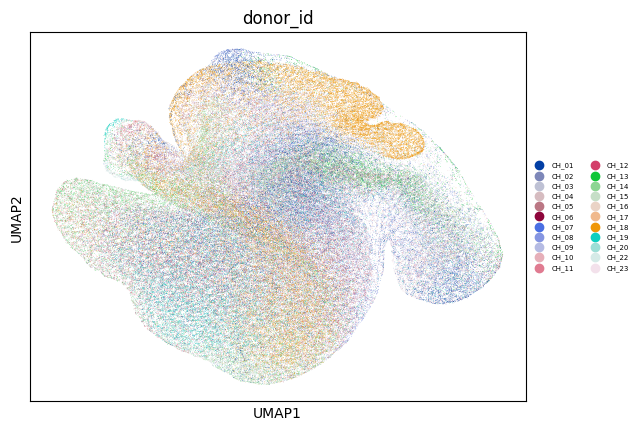

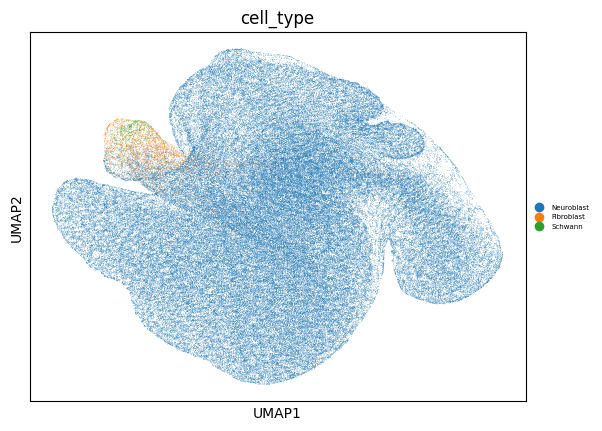

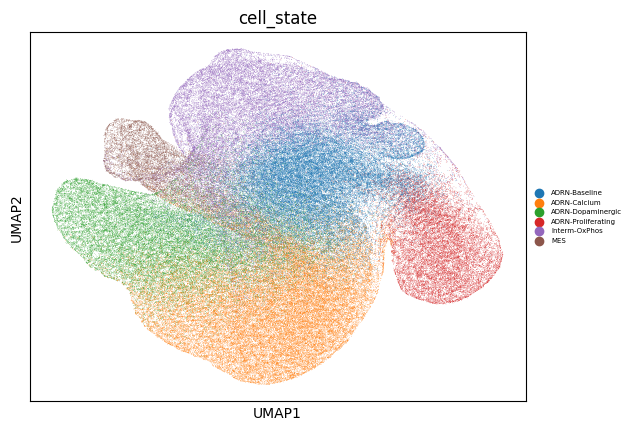

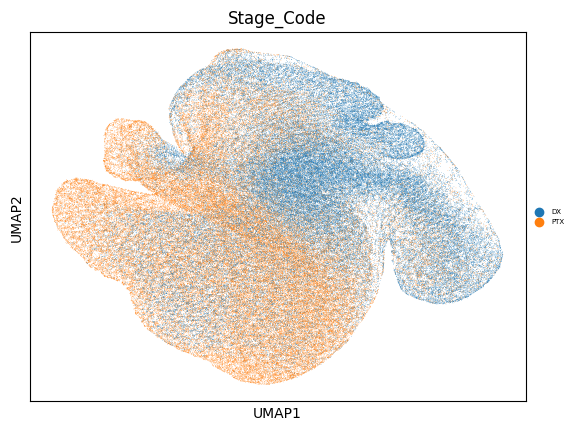

In [30]:
sc.tl.umap(adata)
umap_obs = ['donor_id', 'cell_type', 'cell_state', 'Stage_Code']
for feature in umap_obs:
    sc.pl.umap(adata, color=feature, legend_fontsize=5)